In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, math
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import rescale
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import cv2

# Import data

In [2]:
# Shape, Margin and Texture
data_mar = pd.read_csv('data_Mar_64.txt', header=None)
data_tex = pd.read_csv('data_Tex_64.txt', header=None)
data_sha = pd.read_csv('data_Sha_64.txt', header=None)

In [3]:
classEncoder = LabelEncoder()
trainLabels  = classEncoder.fit_transform(data_mar.iloc[:,0])

# Image registration

In [4]:
imglist = glob.glob(r"data/*/*.jpg")  

# import all images
numImages = len(imglist)
shapesMatrix = np.zeros((2,numImages))
listOfImages = []
for k in range(numImages):
    imageFilename = imglist[k]
    currImage = mpimg.imread(imageFilename)
    shapesMatrix[:,k] = np.shape(currImage)
    listOfImages.append(currImage)

In [5]:
maxShapeSize = shapesMatrix.max(axis=1)
for k in range(len(maxShapeSize)):
    if maxShapeSize[k]%2 == 0:
        maxShapeSize[k] += 311
    else:
        maxShapeSize[k] += 310

In [6]:
# place all original images at the center of the large reference frame
fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize, np.shape(shapesMatrix[1]))).astype(int),dtype=np.dtype('u1'))
destXc = (maxShapeSize[1]+1)/2; destYc = (maxShapeSize[0]+1)/2
for k, currImage in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = destXc - Xc; Yd = destYc - Yc
    rowIndLims = (int(round(Yd)),int(round(Yd)+np.shape(currImage)[0]))
    colIndLims = (int(round(Xd)),int(round(Xd)+np.shape(currImage)[1]))
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1],colIndLims[0]:colIndLims[1],k] = currImage

In [7]:
# re crop according to rows and columns that don't have zeros in them in any image
xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims = (np.nonzero(xValid)[0][0],np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

In [8]:
# scale down all images to be in normal size
rescaleFactor = 0.15

scaledDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage),
                                       np.shape(fullImageMatrix3D)[2])),dtype=np.dtype('f4'))
for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)
    
del fullImageMatrix3D

/home/hutsh/Applications/miniconda3/envs/mlenv/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/hutsh/Applications/miniconda3/envs/mlenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hutsh/Applications/miniconda3/envs/mlenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


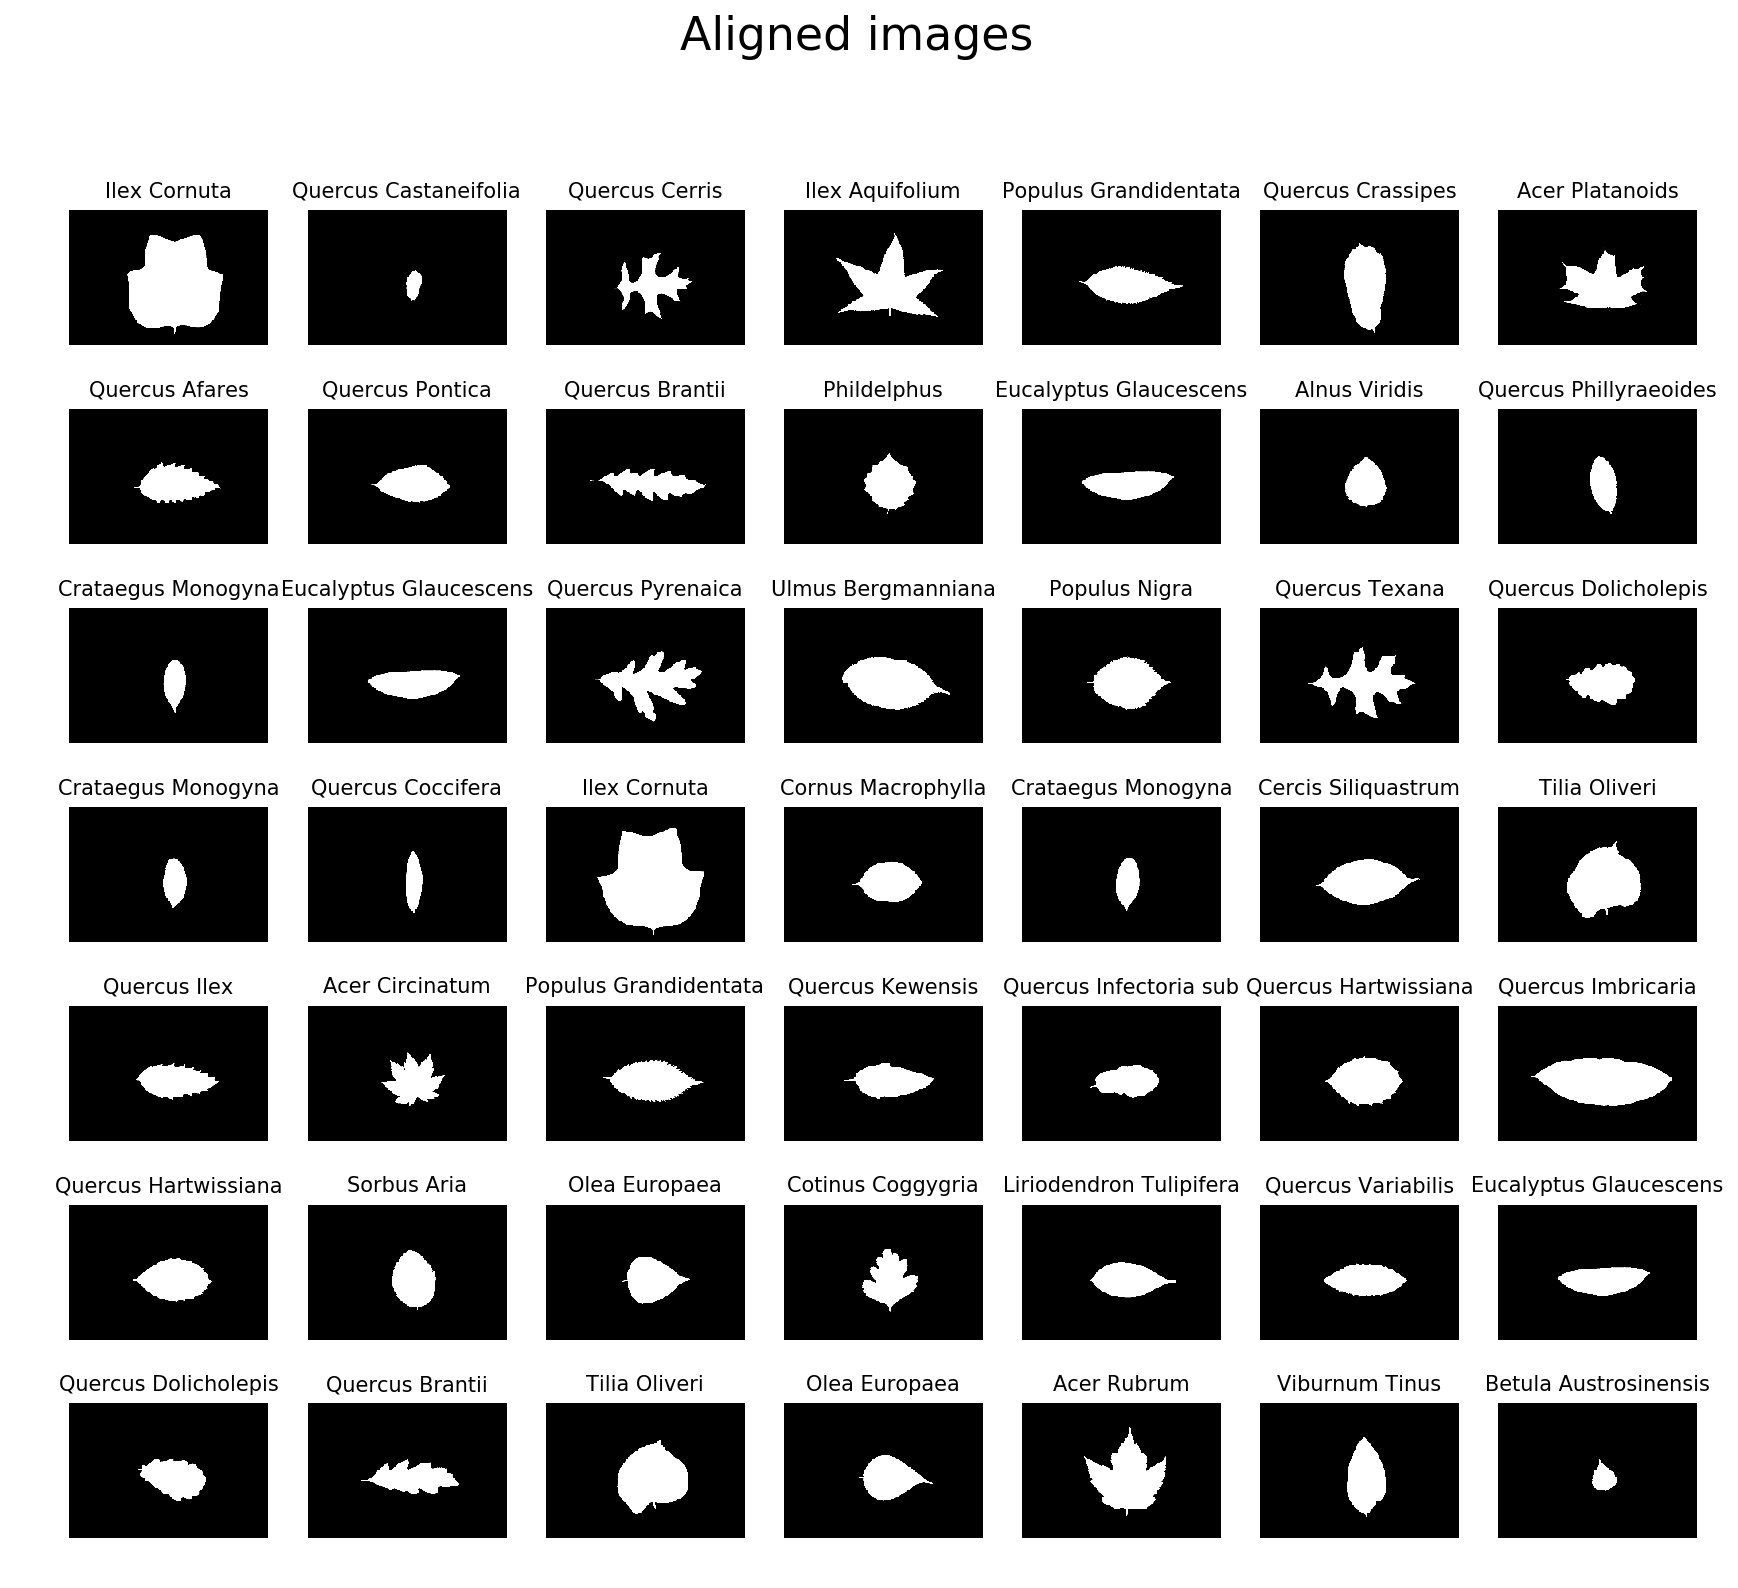

In [9]:
plt.figure(figsize=(14,12), dpi=150)
plt.suptitle('Aligned images', fontsize=22)
for k in range(49):
    randInd = np.random.randint(np.shape(scaledDownImages)[2])
    plt.subplot(7,7,k+1); plt.imshow(scaledDownImages[:,:,randInd], cmap='gray'); plt.axis('off')
    if randInd < len(trainLabels):
        plt.title(classEncoder.classes_[trainLabels[randInd]], fontsize=10)
    else:
        plt.title('test data sample', fontsize=10)

# average img of each type

In [10]:
ave_matrix = np.zeros((170,250,100))
for i in range(100):
    combine = np.zeros((170,250))
    for j in range(16):
        combine += scaledDownImages[:,:,j+i*16]
    ave_matrix[:,:,i] = combine

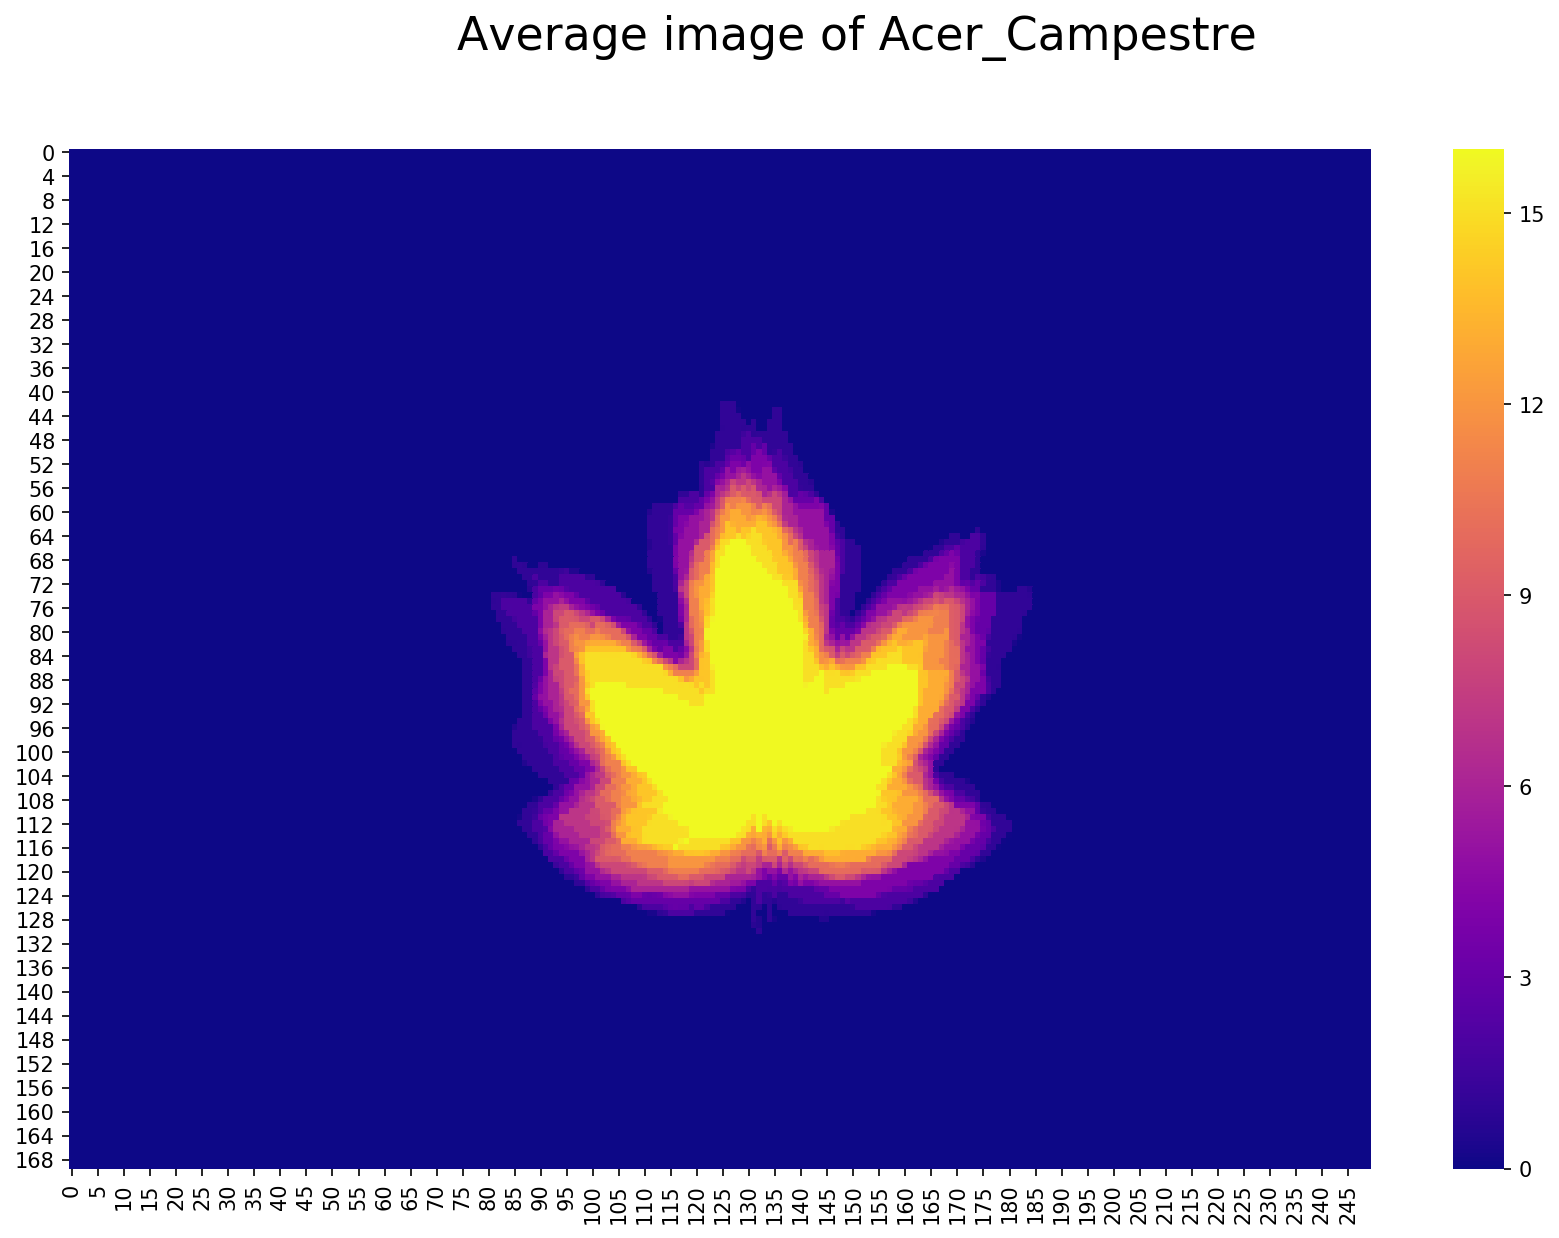

In [11]:
plt.figure(figsize=(14,9), dpi=150)
plt.suptitle('Average image of Acer_Campestre', fontsize=22)
sns.heatmap(ave_matrix[:,:,0], cmap="plasma")

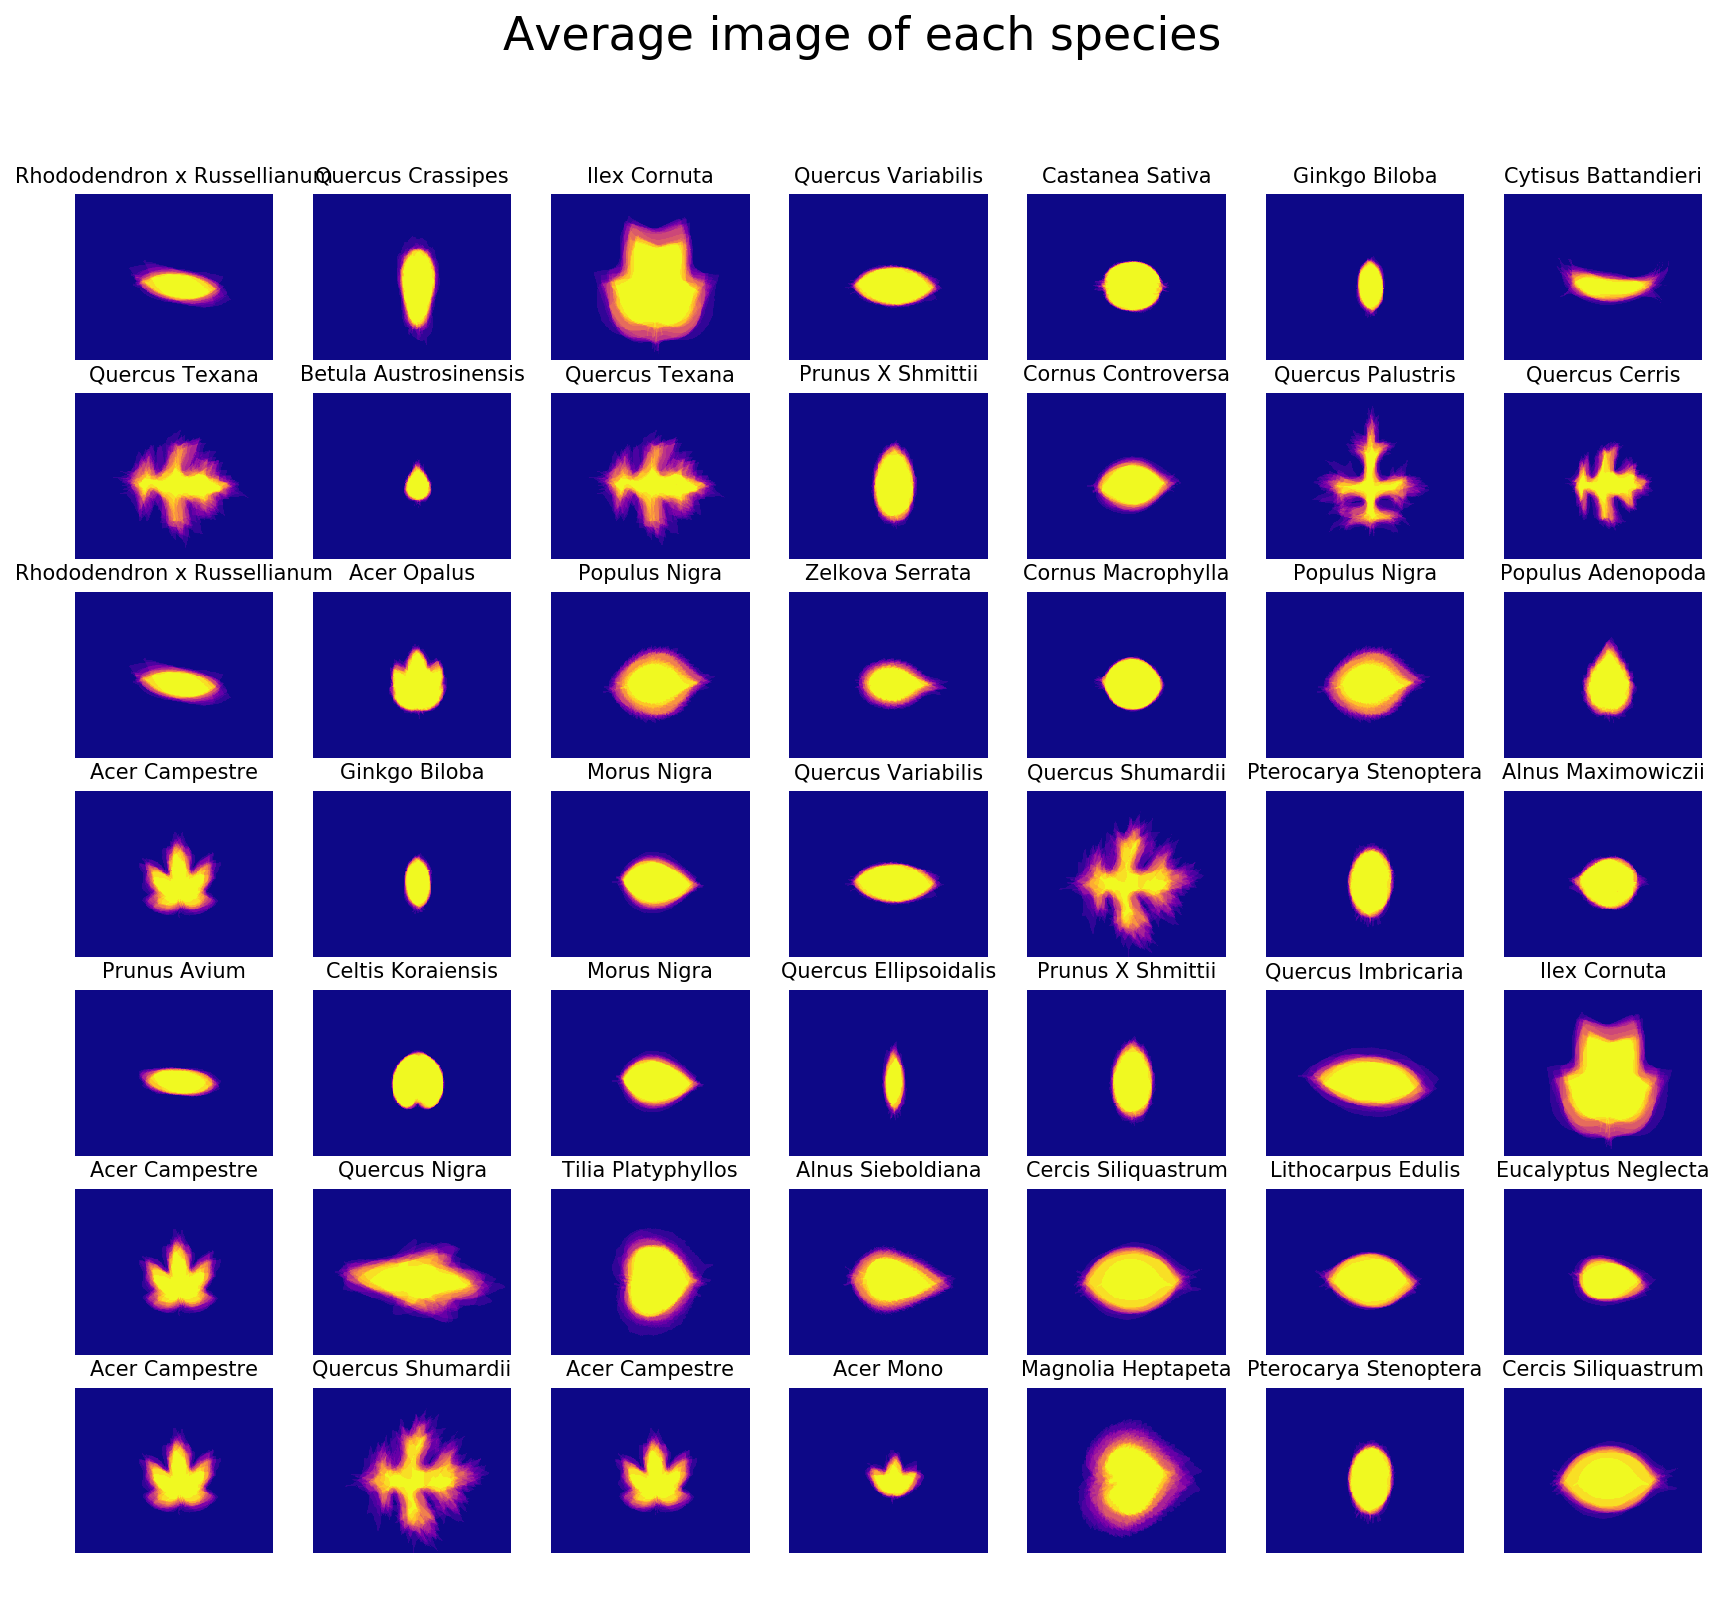

In [12]:
plt.figure(figsize=(14,12), dpi=150)
plt.suptitle('Average image of each species', fontsize=22)
for k in range(49):
    randInd = np.random.randint(np.shape(ave_matrix)[2])
    plt.subplot(7,7,k+1); 
    sns.heatmap(ave_matrix[:,:,randInd], cbar=False, cmap="plasma")
#     plt.imshow(ave_matrix[:,:,randInd], cmap='gray'); 
    plt.axis('off')
    if randInd < len(trainLabels):
        plt.title(classEncoder.classes_[trainLabels[randInd*16]], fontsize=10)
    else:
        plt.title('test data sample', fontsize=10)

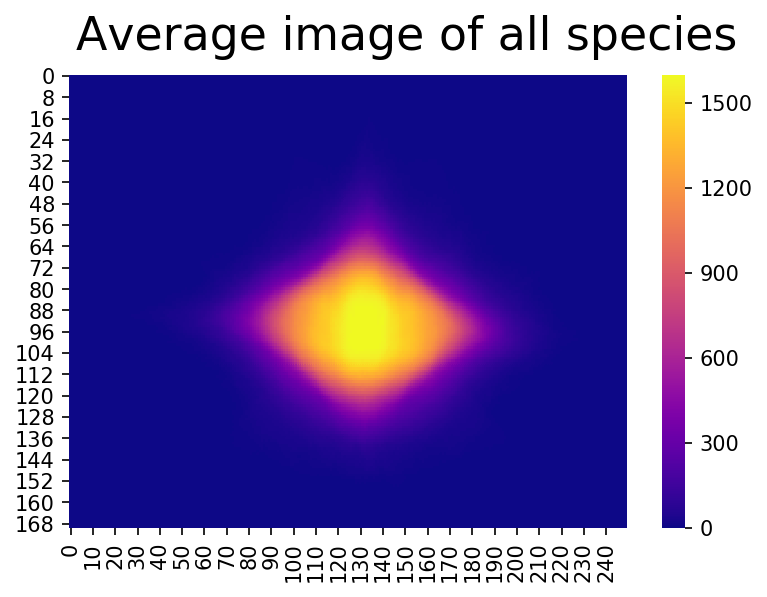

In [13]:
average_all = np.zeros((170,250))
for i in range(100):
    average_all += ave_matrix[:,:,i]
plt.figure(dpi=150)
plt.suptitle('Average image of all species', fontsize=22)
sns.heatmap(average_all[:,:], cmap="plasma")

# Eignvectors

In [14]:
scaledDownImages.shape

(170, 250, 1600)

In [15]:
sz = (170, 250)
flatten_img = np.zeros((1600,42500))
for i in range(1600):
    flatten_img[i,:] = scaledDownImages[:,:,i].flatten()

In [16]:
if os.path.exists('mean.npy') and os.path.exists('eigenVectors.npy'):
    mean = np.load('mean.npy')
    eigenVectors = np.load('eigenVectors.npy')
else:
    mean, eigenVectors = cv2.PCACompute(flatten_img, mean=None, maxComponents=10)
    mean.dump('mean.npy')
    eigenVectors.dump('eigenVectors.npy')

In [17]:
eigenLeafs = [];
for eigenVector in eigenVectors:
    eigenLeaf = eigenVector.reshape(sz)
    eigenLeafs.append(eigenLeaf)

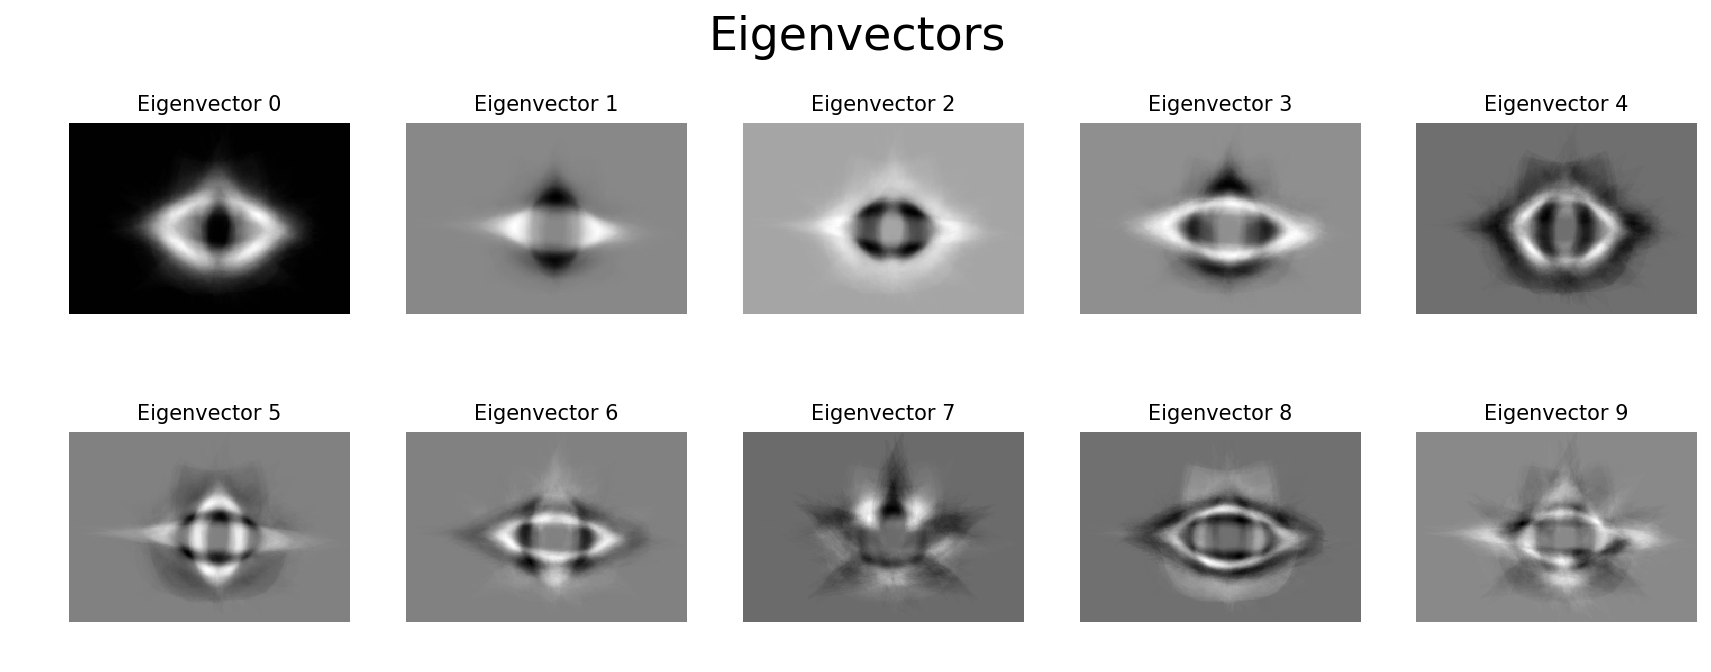

In [18]:
plt.figure(figsize=(14,5), dpi=150)
plt.suptitle('Eigenvectors', fontsize=22)
for k in range(10):
    plt.subplot(2,5,k+1); 
    plt.imshow(eigenLeafs[k], cmap='gray')
    plt.title('Eigenvector '+str(k), fontsize=10)
    plt.axis('off')

In [19]:
averageLeaf = mean.reshape(sz)

In [20]:
def buildLeaf(weight_args):
    output = averageLeaf
    for i in range(NUM_EIGEN_FACES):
        weight = weight_args[i] - MAX_SLIDER_VALUE/2
        output = np.add(output, eigenLeafs[i] * weight)
    return output

NUM_EIGEN_FACES = 10
MAX_SLIDER_VALUE = 255

outputs = []

for i in range(10):
    weight_args = [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
    weight_args_0 = weight_args.copy(); weight_args_0[i] = 0
    weight_args_85 = weight_args.copy(); weight_args_85[i] = 85
    weight_args_170 = weight_args.copy(); weight_args_170[i] = 170
    weight_args_255 = weight_args.copy(); weight_args_255[i] = 255
    argslist = [weight_args_0, weight_args_85, weight_args_170, weight_args_255]
    for arg in argslist:
#         print(arg)
        out = buildLeaf(arg)
        outputs.append(out)

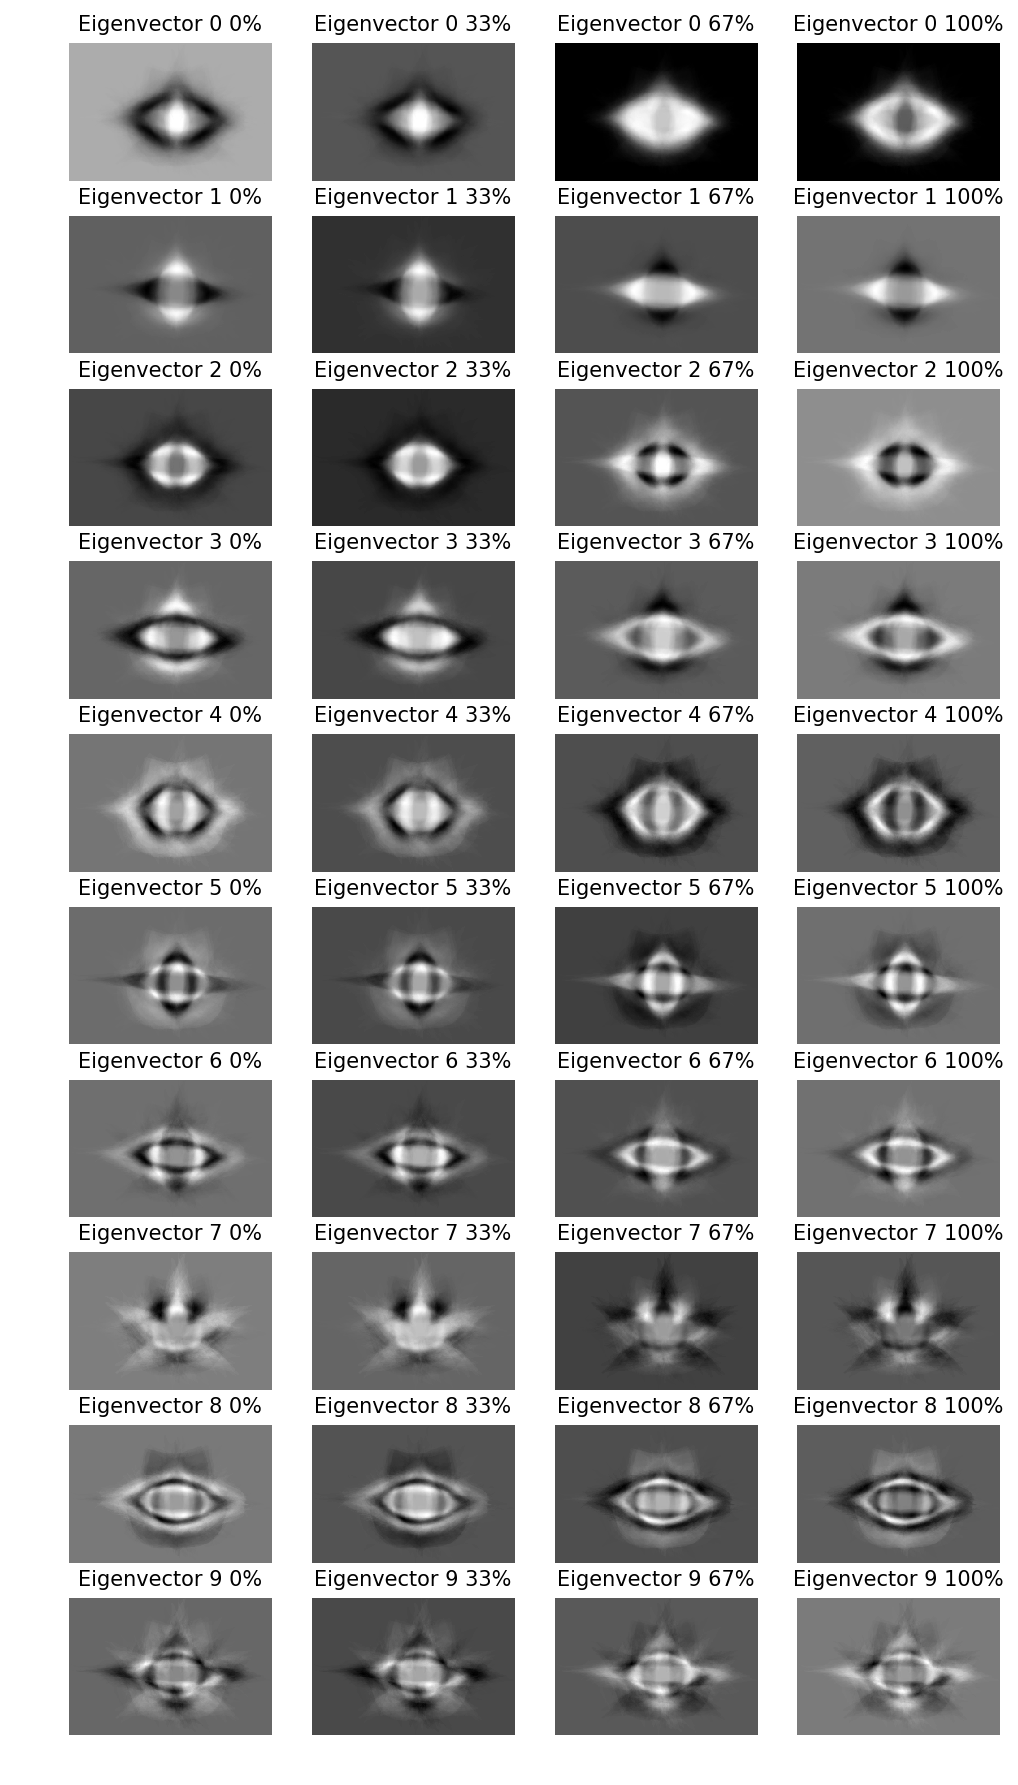

In [21]:
plt.figure(figsize=(8,15), dpi=150)
for k in range(40):
    plt.subplot(10,4,k+1); 
    plt.imshow(outputs[k], cmap='gray')
    plt.title('Eigenvector ' + str(math.floor(k/4)) + " " + str(round(k%4*85/2.55))+ '%', fontsize=10)
    plt.axis('off')

# Correlation matrix

Text(0.5, 0.98, 'Correlation Matrix (Margin)')

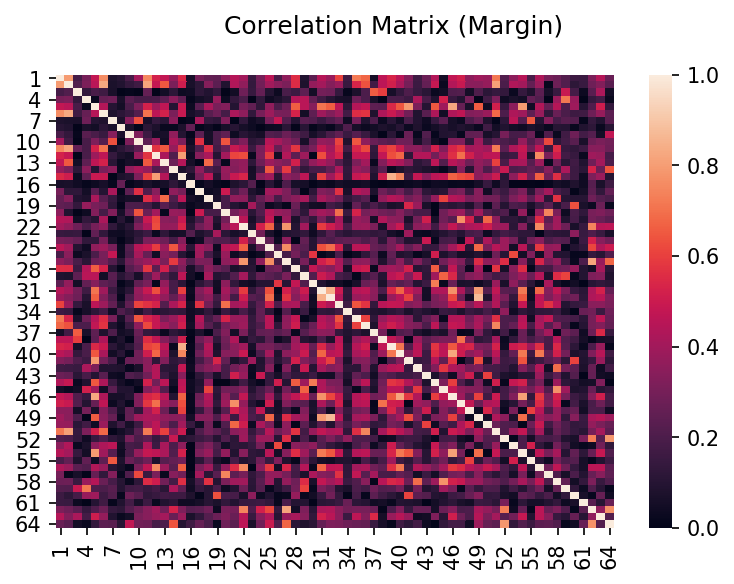

In [22]:
plt.subplots(dpi=150)
corr_matrix = data_mar.iloc[:,1:].corr().abs()
sns.heatmap(corr_matrix);
plt.suptitle('Correlation Matrix (Margin)')

Text(0.5, 0.98, 'Correlation Matrix (Texture)')

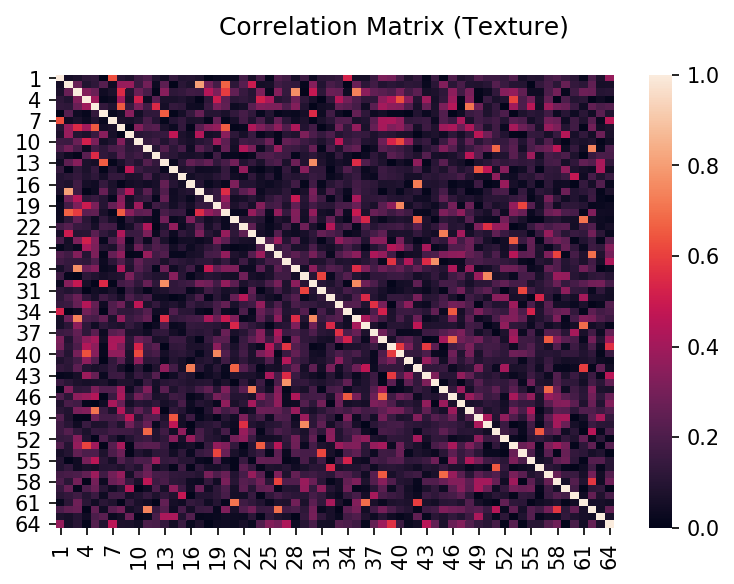

In [23]:
plt.subplots(dpi=150)
corr_matrix = data_tex.iloc[:,1:].corr().abs()
sns.heatmap(corr_matrix);
plt.suptitle('Correlation Matrix (Texture)')

Text(0.5, 0.98, 'Correlation Matrix (Shape)')

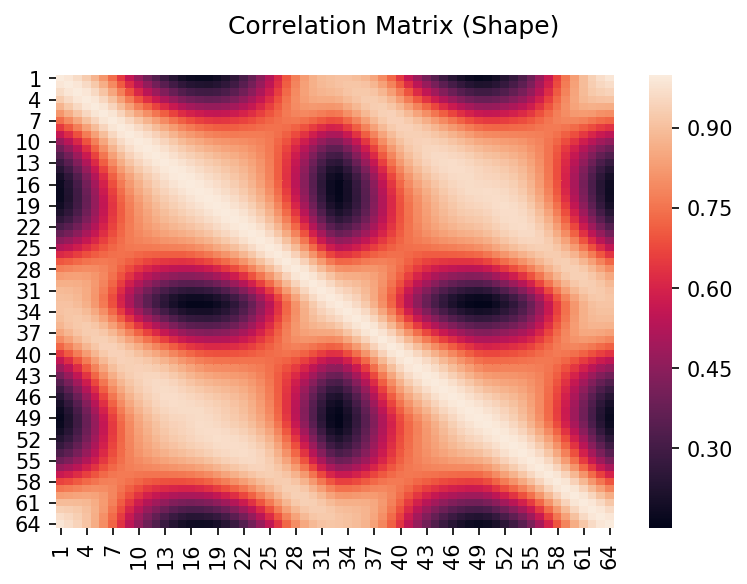

In [24]:
plt.subplots(dpi=150)
corr_matrix = data_sha.iloc[:,1:].corr().abs()
sns.heatmap(corr_matrix);
plt.suptitle('Correlation Matrix (Shape)')

# PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
# data_mar = pd.read_csv('data_Mar_64.txt', header=None)
# data_tex = pd.read_csv('data_Tex_64.txt', header=None)
# data_sha = pd.read_csv('data_Sha_64.txt', header=None)
pca_mar = PCA().fit(data_mar.iloc[:,1:])
pca_tex = PCA().fit(data_tex.iloc[:,1:])
pca_sha = PCA().fit(data_sha.iloc[:,1:])

In [27]:
mar_pca_explained = pd.DataFrame(np.cumsum(pca_mar.explained_variance_ratio_)); mar_pca_explained['X']=np.linspace(0, 63, num=64); mar_pca_explained['Feature'] = 'Margin'
tex_pca_explained = pd.DataFrame(np.cumsum(pca_tex.explained_variance_ratio_)); tex_pca_explained['X']=np.linspace(0, 63, num=64); tex_pca_explained['Feature'] = 'Texture'
sha_pca_explained = pd.DataFrame(np.cumsum(pca_sha.explained_variance_ratio_)); sha_pca_explained['X']=np.linspace(0, 63, num=64); sha_pca_explained['Feature'] = 'Shape'
all_pac_explained = mar_pca_explained.append([tex_pca_explained, sha_pca_explained])
all_pac_explained.columns = [r'Explained (%)', 'Number of Components', 'Feature']

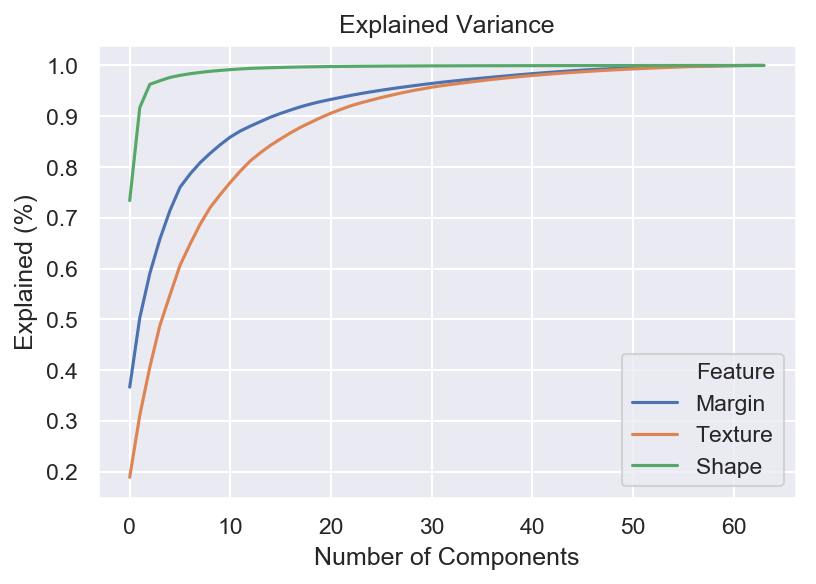

In [28]:
sns.set()
plt.subplots(dpi=150)
plt.title('Explained Variance')
ax = sns.lineplot(x='Number of Components', y=r'Explained (%)', hue='Feature', data=all_pac_explained)

Text(0.5, 1.0, 'PCA (Margin)')

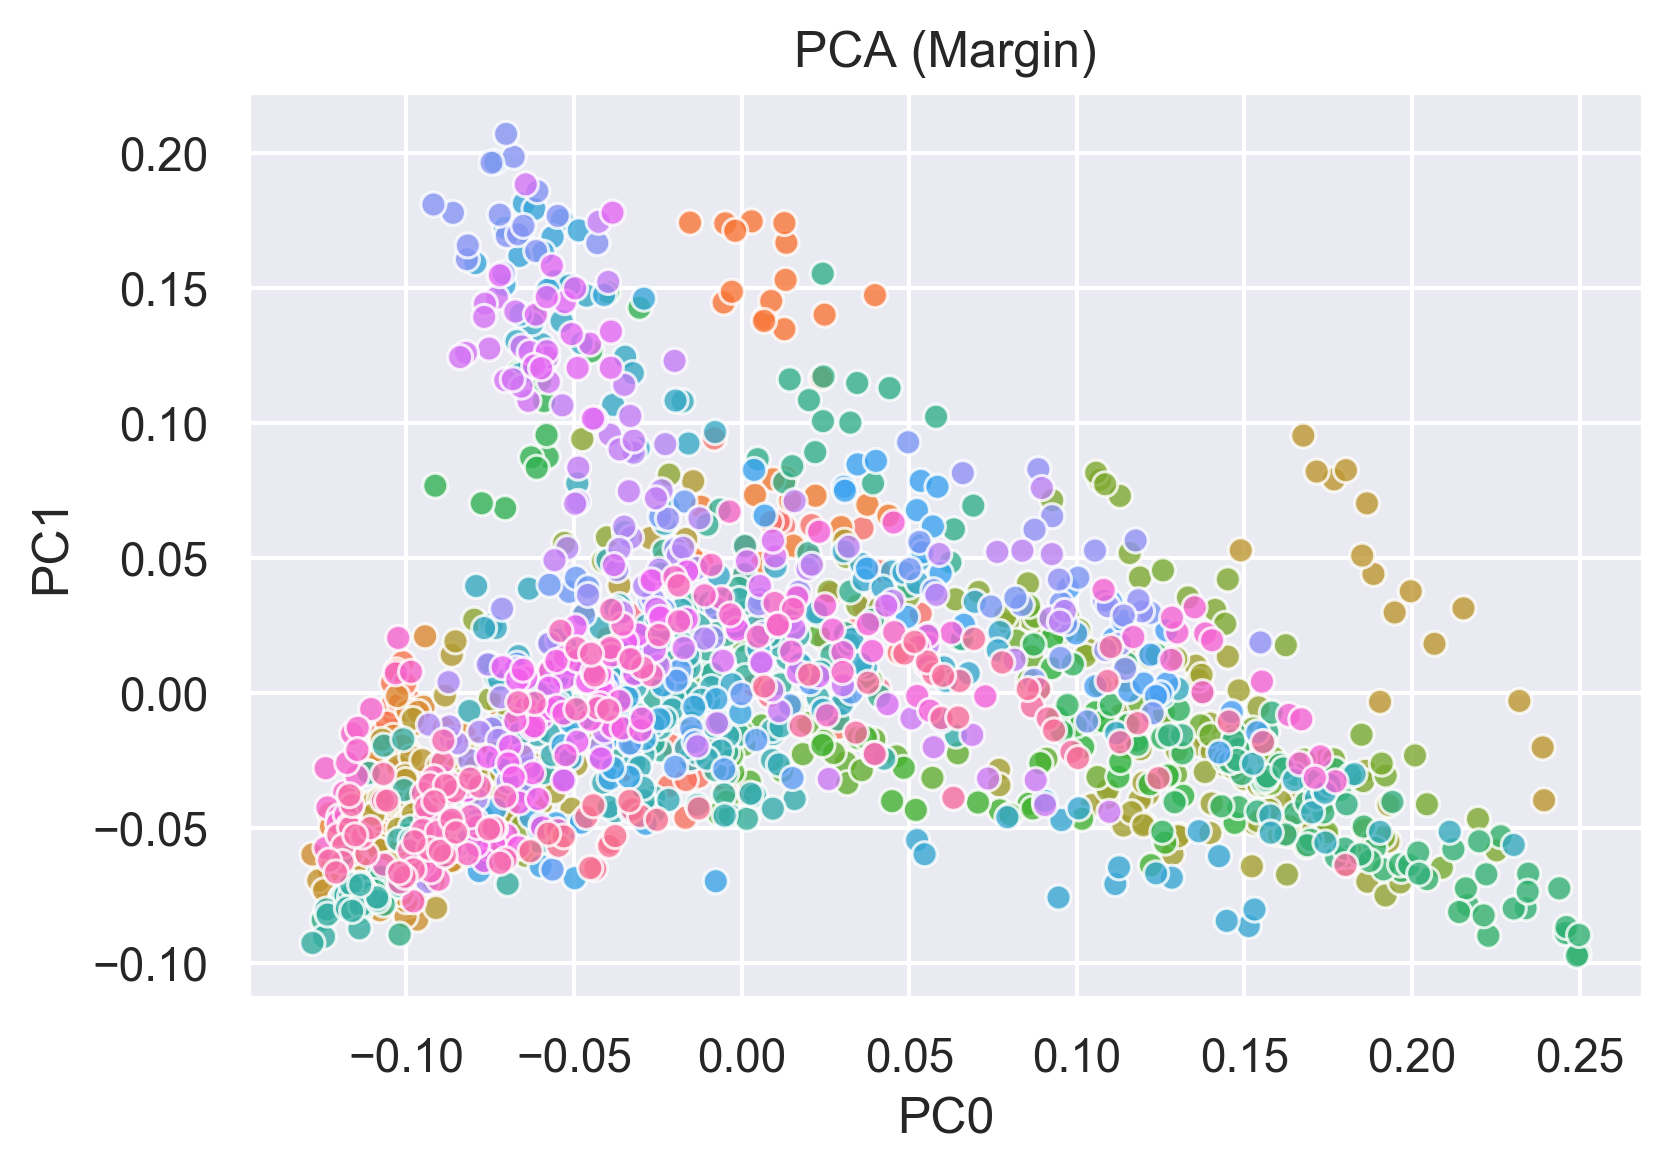

In [29]:
data_transformed_pca_mar=pca_mar.transform(data_mar.iloc[:,1:])
pca_mar_df = pd.DataFrame(data_transformed_pca_mar)

fig, ax = plt.subplots(dpi=300)
sns.scatterplot(pca_mar_df[0], pca_mar_df[1], hue=data_mar.iloc[:,0], alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='PC0', ylabel='PC1')
plt.title('PCA (Margin)')

Text(0.5, 1.0, 'PCA (Texture)')

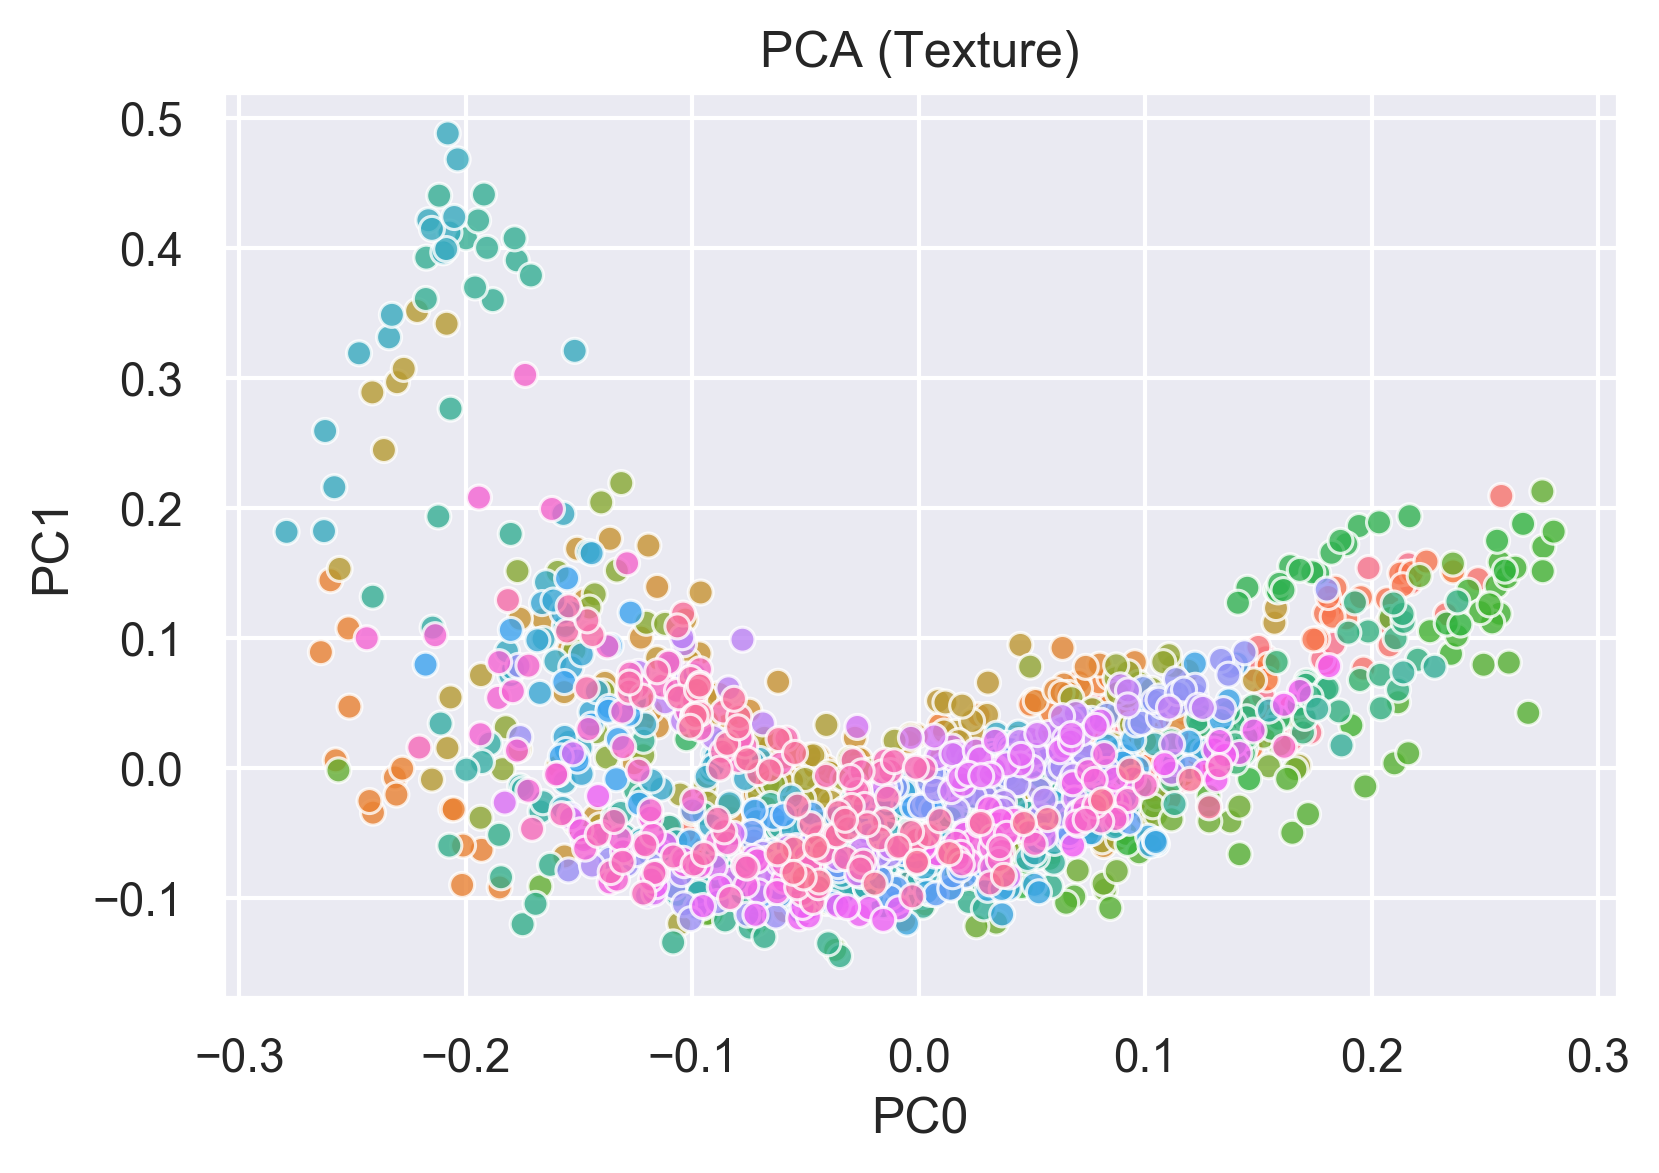

In [30]:
data_transformed_pca_tex=pca_tex.transform(data_tex.iloc[:,1:])
pca_tex_df = pd.DataFrame(data_transformed_pca_tex)

fig, ax = plt.subplots(dpi=300)
sns.scatterplot(pca_tex_df[0], pca_tex_df[1], hue=data_tex.iloc[:,0], alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='PC0', ylabel='PC1')
plt.title('PCA (Texture)')

Text(0.5, 1.0, 'PCA (Shape)')

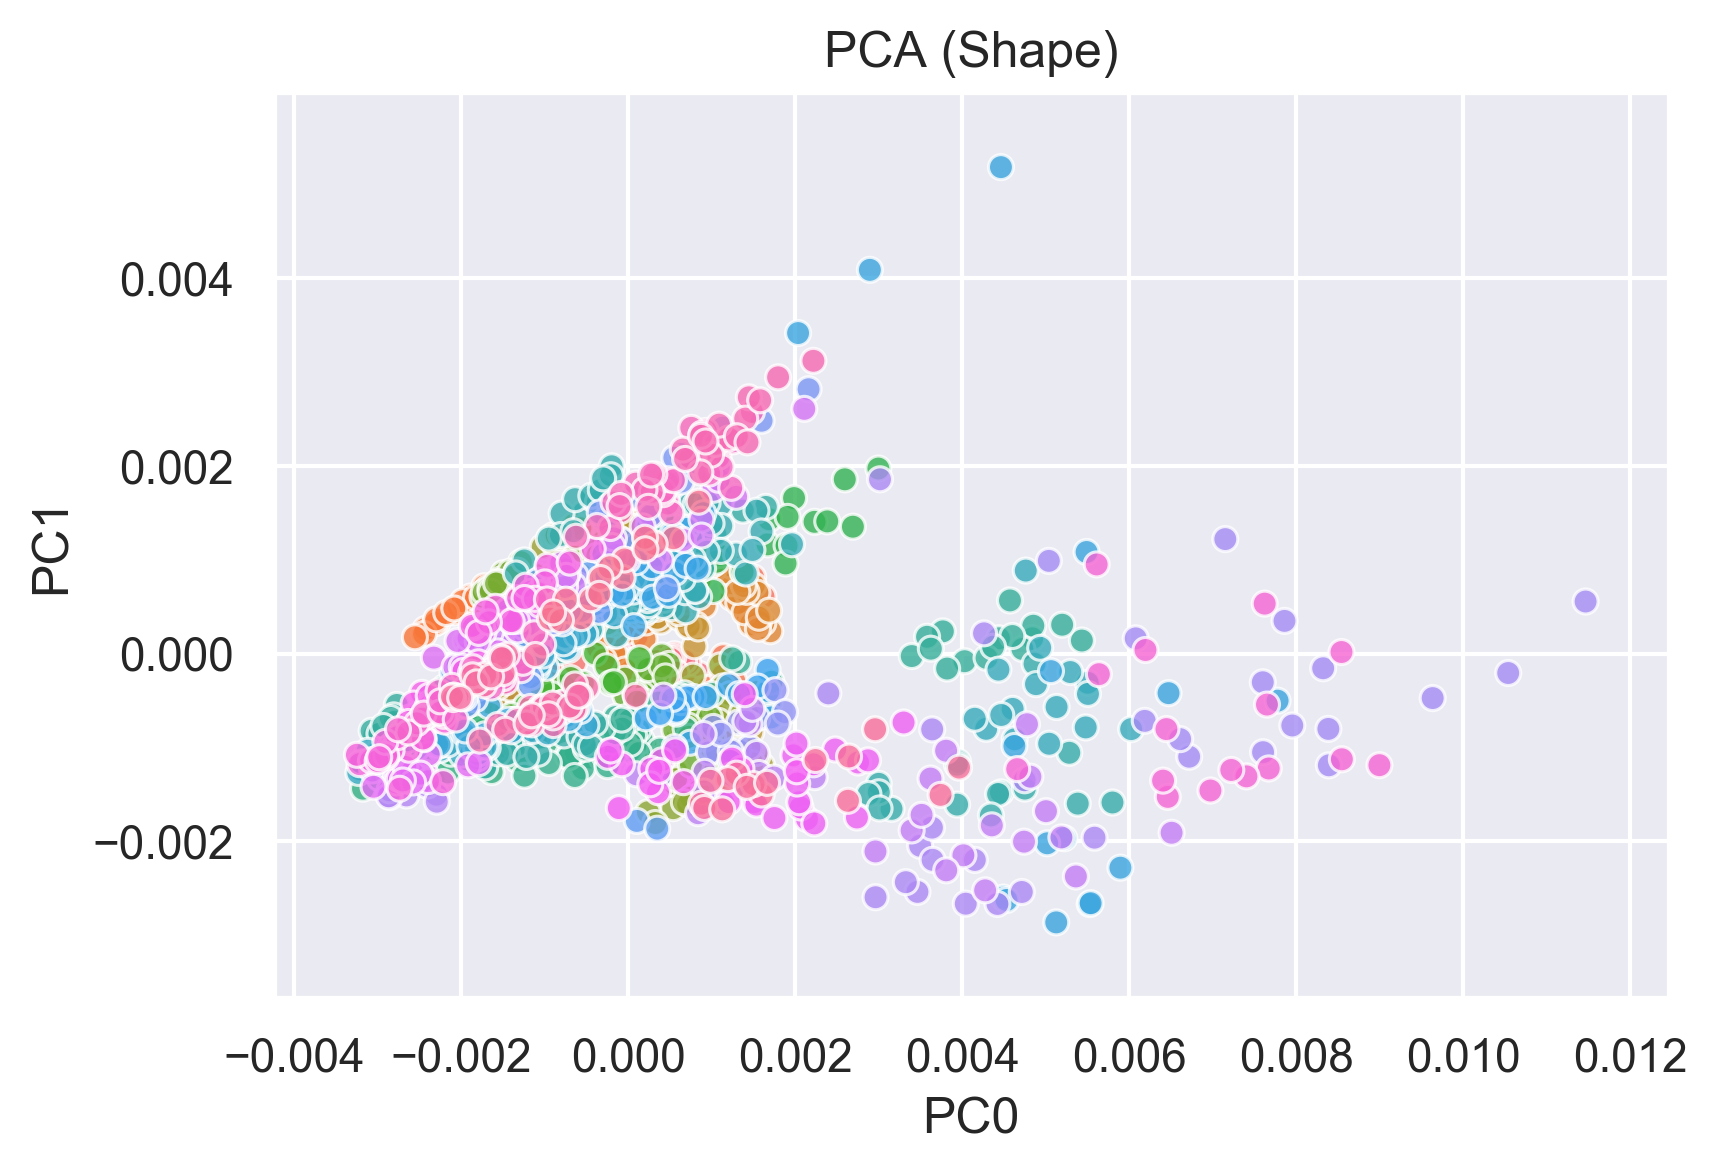

In [31]:
data_transformed_pca_sha=pca_sha.transform(data_sha.iloc[:,1:])
pca_sha_df = pd.DataFrame(data_transformed_pca_sha)

fig, ax = plt.subplots(dpi=300)
sns.scatterplot(pca_sha_df[0], pca_sha_df[1], hue=data_sha.iloc[:,0], alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='PC0', ylabel='PC1')
plt.title('PCA (Shape)')

# TSNE

In [32]:
from sklearn.manifold import TSNE
import matplotlib

In [33]:
species_sha = data_sha.iloc[:,0]
data_sha = data_sha.iloc[:,1:]
tsne_sha = TSNE()
X_tsne_sha = tsne_sha.fit_transform(np.array(data_sha))
tsne_transformed_sha = pd.DataFrame(X_tsne_sha)

Text(0.5, 1.0, 't-SNE (Shape)')

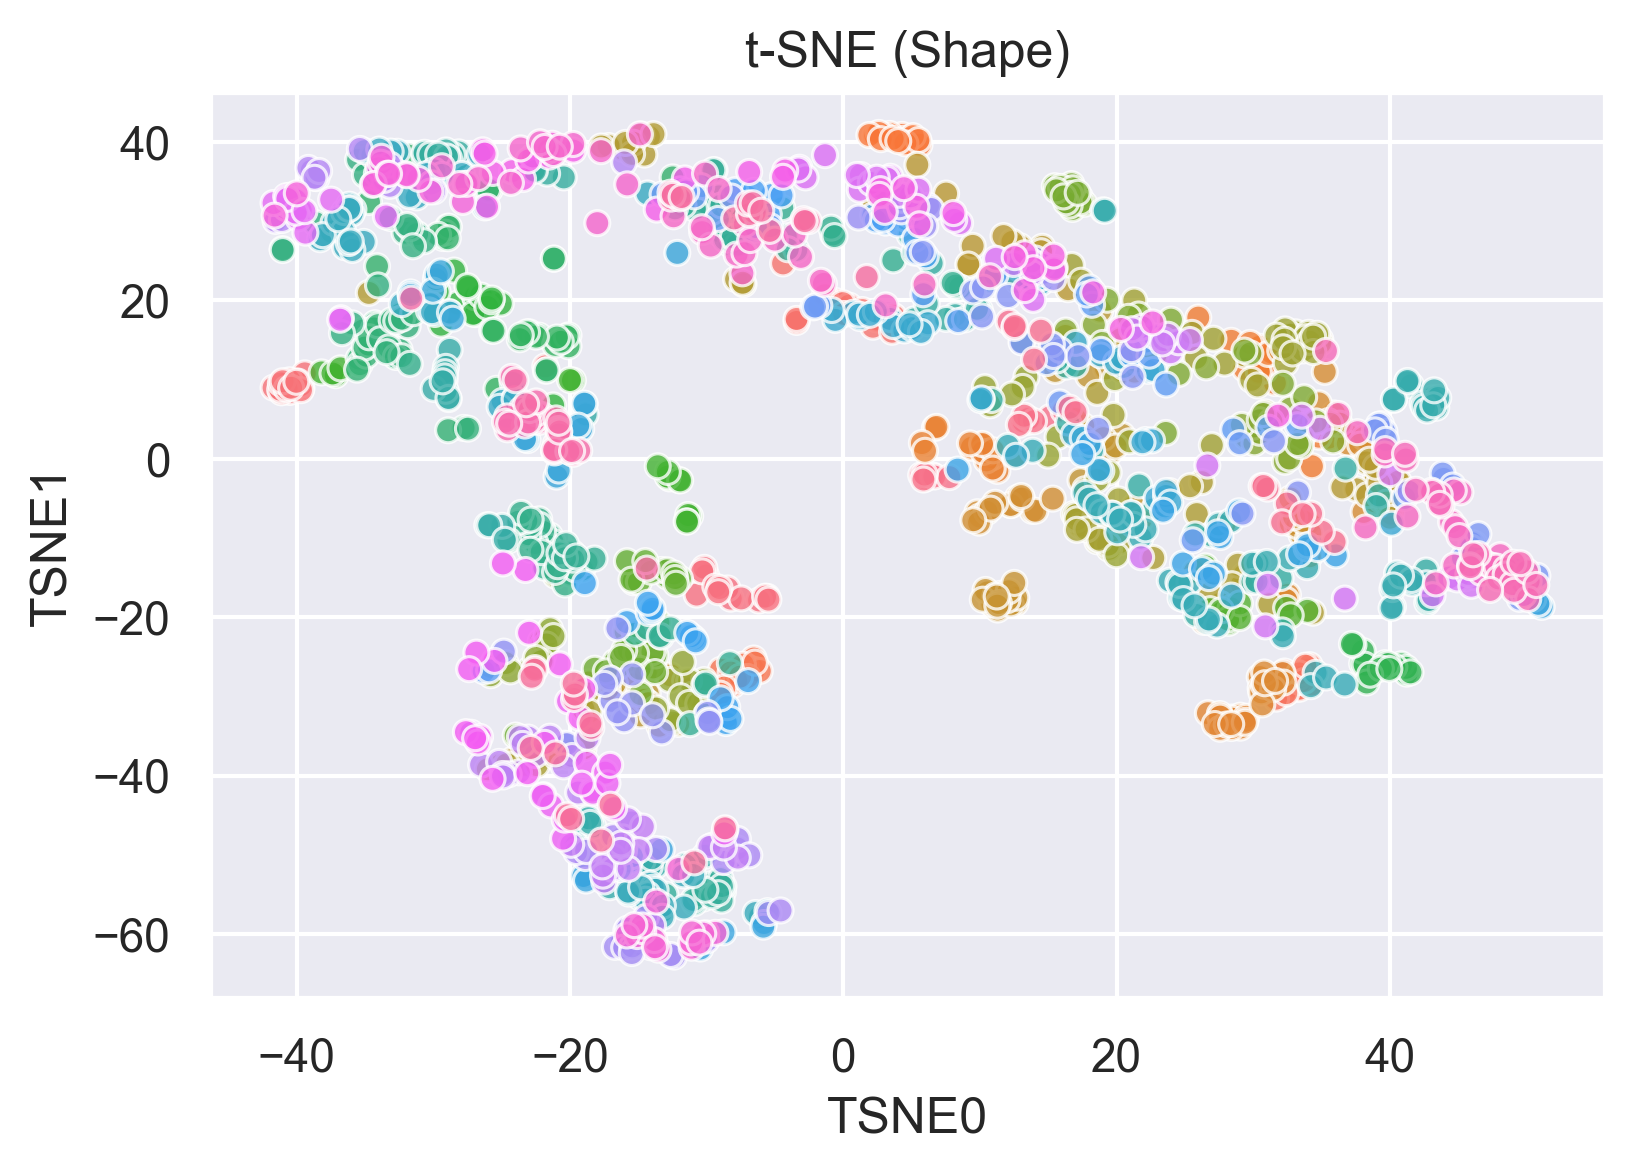

In [34]:
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(tsne_transformed_sha[0], tsne_transformed_sha[1], hue=species_sha, alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='TSNE0', ylabel='TSNE1')
plt.title('t-SNE (Shape)')

Text(0.5, 1.0, 't-SNE (Texture)')

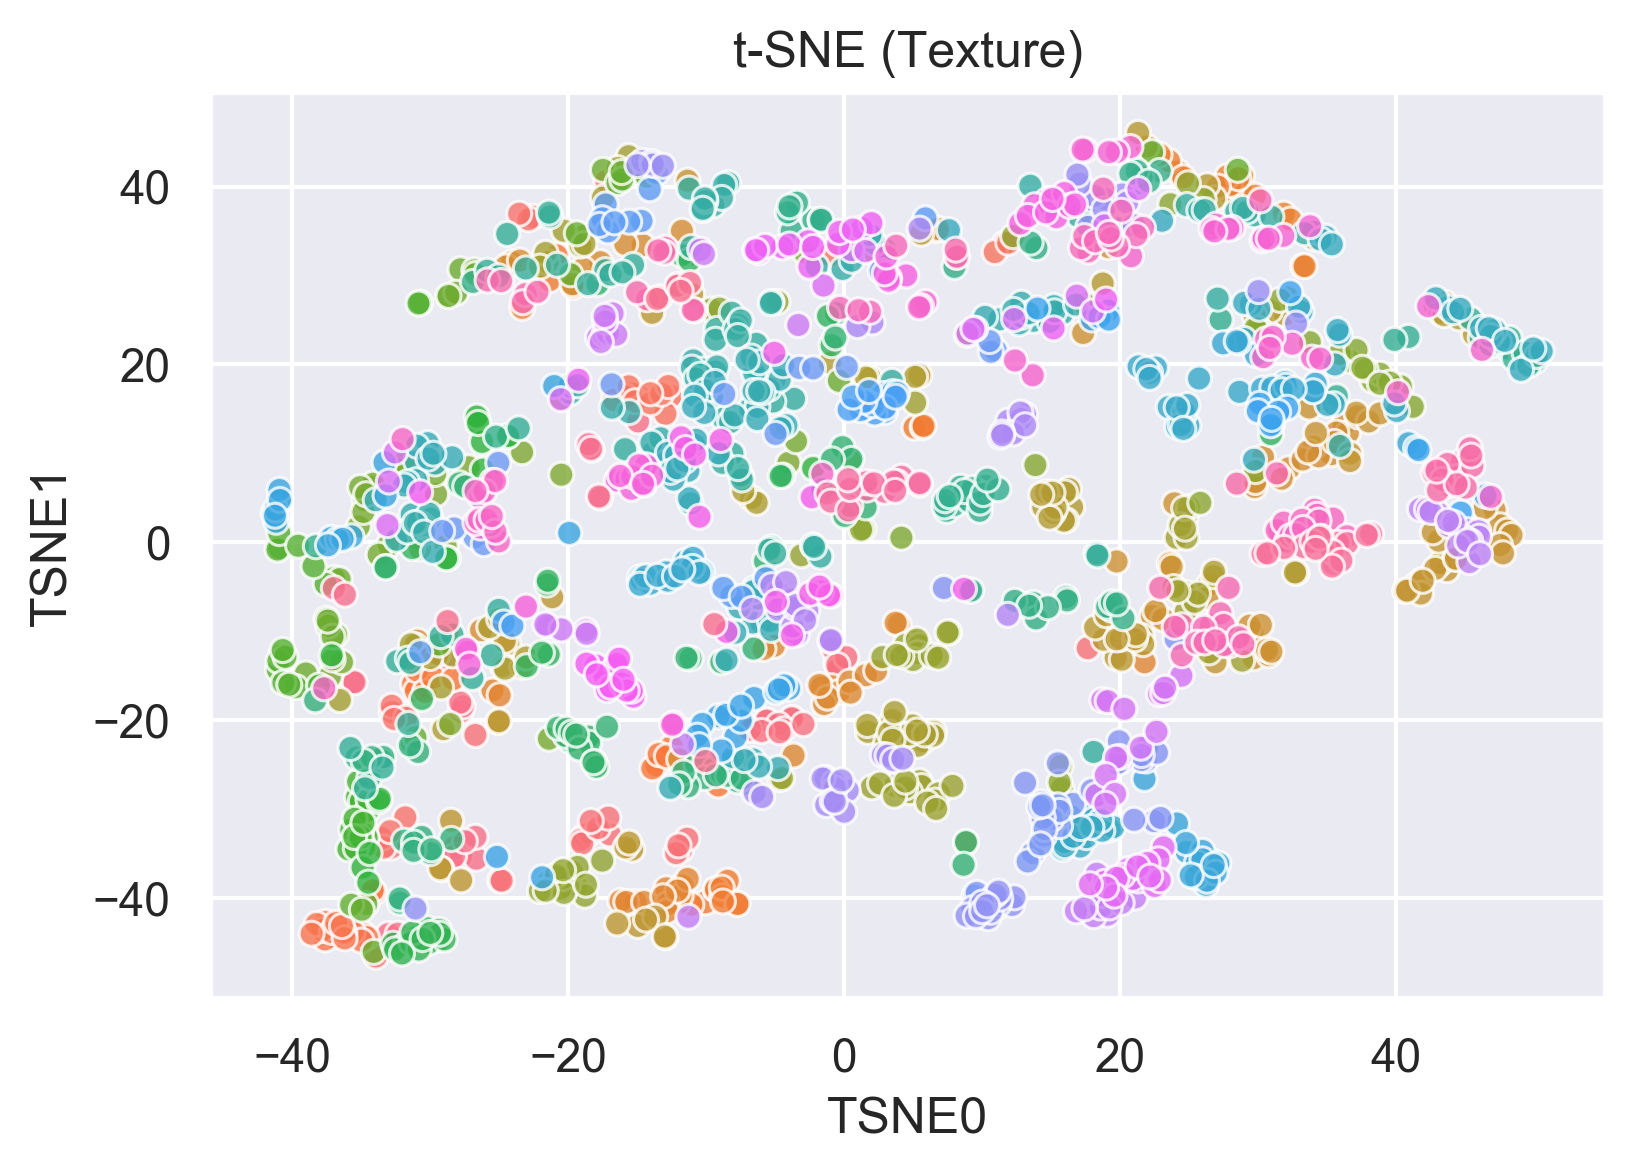

In [35]:
species_tex = data_tex.iloc[:,0]
data_tex = data_tex.iloc[:,1:]
tsne_tex = TSNE()
X_tsne_tex = tsne_tex.fit_transform(np.array(data_tex))
tsne_transformed_tex = pd.DataFrame(X_tsne_tex)

fig, ax = plt.subplots(dpi=300)
sns.scatterplot(tsne_transformed_tex[0], tsne_transformed_tex[1], hue=species_tex, alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='TSNE0', ylabel='TSNE1')
plt.title('t-SNE (Texture)')

Text(0.5, 1.0, 't-SNE (Margin)')

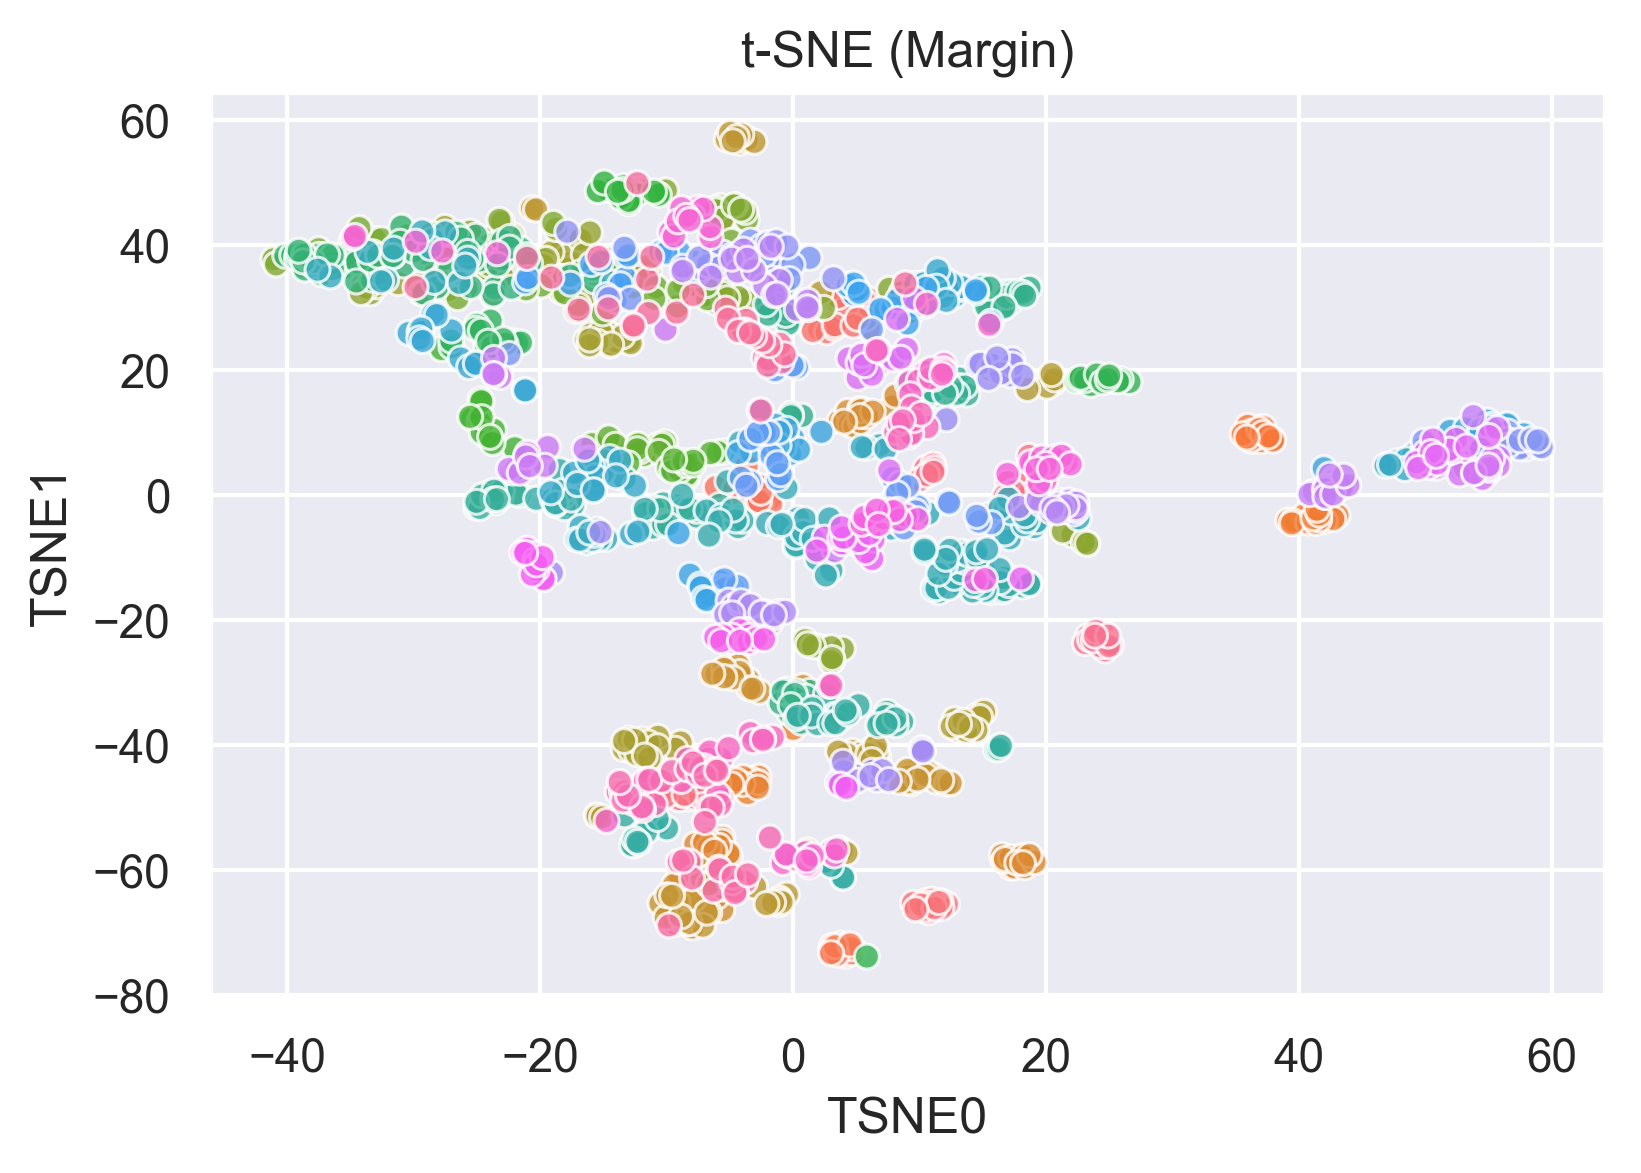

In [36]:
species_mar = data_mar.iloc[:,0]
data_mar = data_mar.iloc[:,1:]
tsne_mar = TSNE()
X_tsne_mar = tsne_mar.fit_transform(np.array(data_mar))
tsne_transformed_mar = pd.DataFrame(X_tsne_mar)

fig, ax = plt.subplots(dpi=300)
sns.scatterplot(tsne_transformed_mar[0], tsne_transformed_mar[1], hue=species_mar, alpha=0.8, ax=ax, legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.set(xlabel='TSNE0', ylabel='TSNE1')
plt.title('t-SNE (Margin)')

# Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
mar_lables  = classEncoder.fit_transform(species_mar)

Text(0.5, 1.0, 'Decision Tree Classifier')

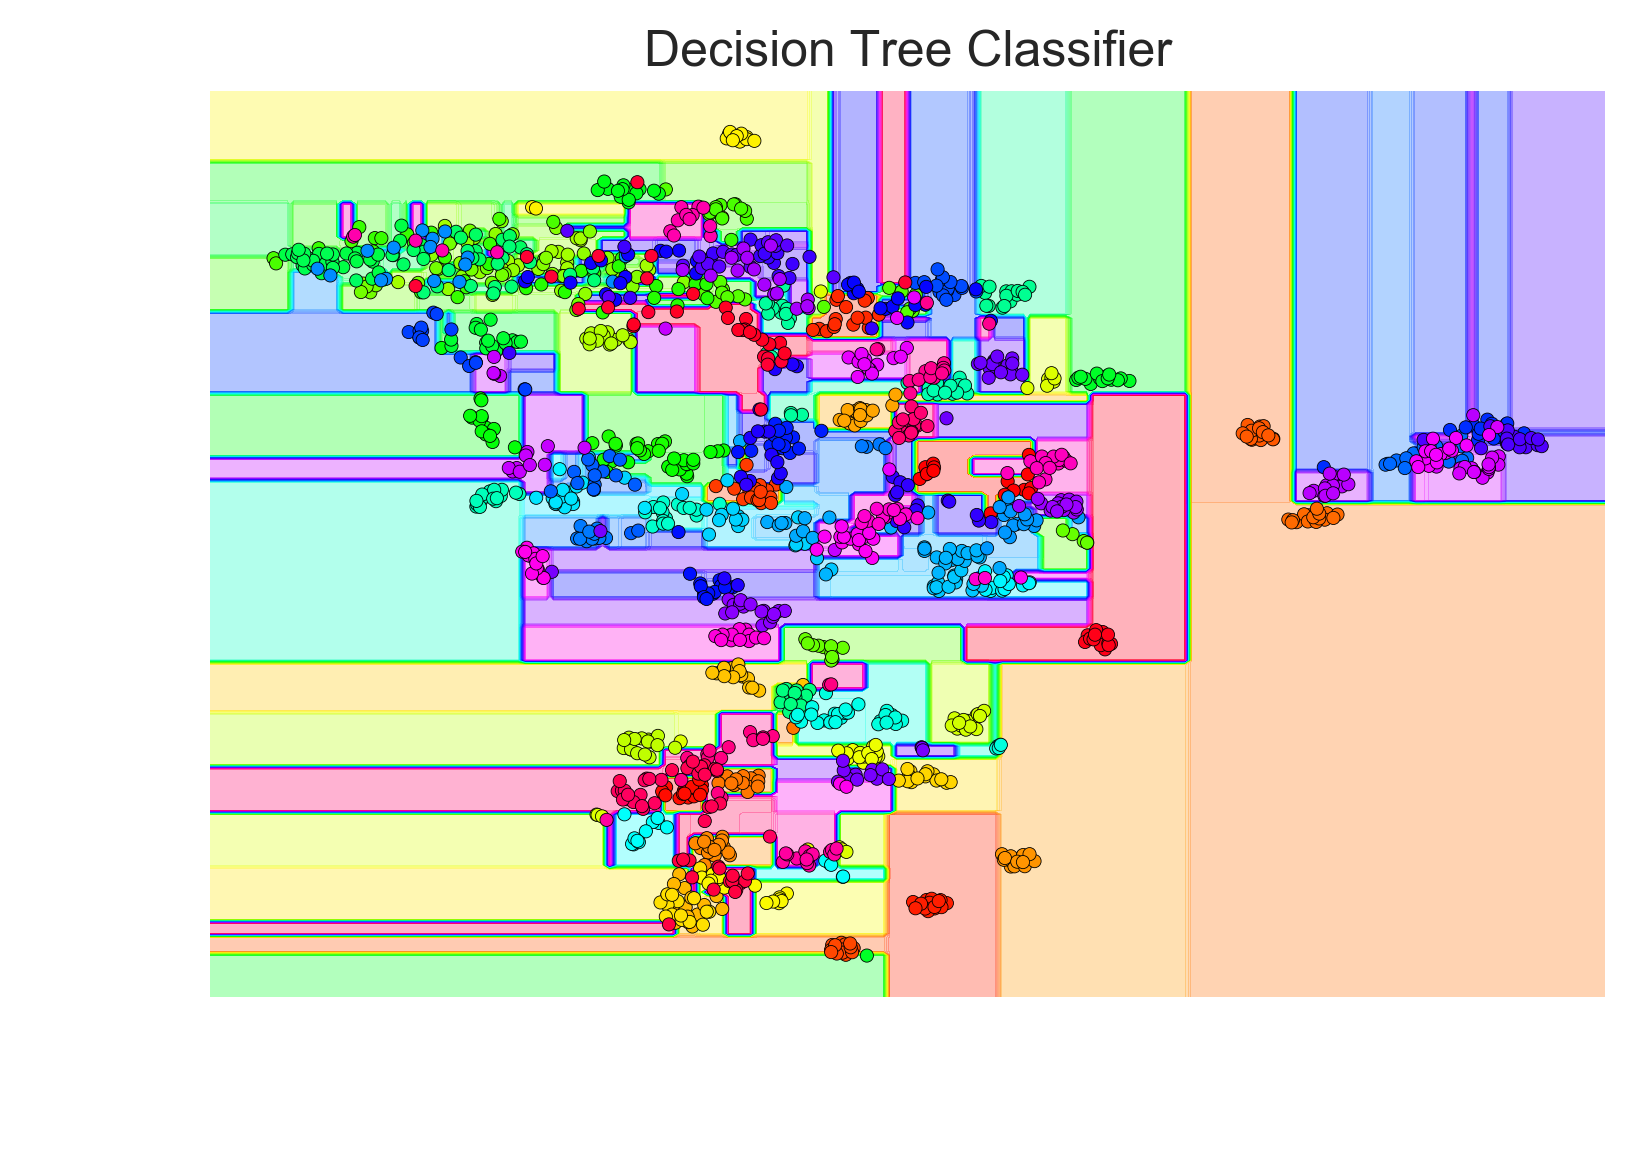

In [38]:

fig, ax = plt.subplots(dpi=300)

# Plot the training points

sns.scatterplot(tsne_transformed_mar.iloc[:, 0], tsne_transformed_mar.iloc[:, 1], 
                s=10, linewidth=0.2, edgecolor='black',legend=False, hue=mar_lables, palette='hsv')
# ax.scatter(tsne_transformed_mar.iloc[:, 0], tsne_transformed_mar.iloc[:, 1], c=mar_lables, s=30, cmap='hsv',
#            clim=(mar_lables.min(), mar_lables.max()), zorder=3)
ax.axis('tight')
ax.axis('off')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# fit the estimator
tree = DecisionTreeClassifier().fit(tsne_transformed_mar, mar_lables)
xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Create a color plot with the results
n_classes = len(np.unique(mar_lables))
contours = ax.contourf(xx, yy, Z, alpha=0.3,
                       levels=np.arange(n_classes + 1) - 0.5,
                       cmap='hsv',
                       zorder=0)
plt.title('Decision Tree Classifier')